In [302]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [376]:
df = pd.read_csv("./arkansas_chr/2023-Table 1.csv")

In [377]:
#remove for sure non-used columns
cols_95_to_drop = [col for col in df.columns if '95%' in col]
cols_unreliable_to_drop = [col for col in df.columns if 'Unreliable' in col]
cols_to_drop = cols_95_to_drop + cols_unreliable_to_drop
#rate_cols = [col for col in df.columns if 'Rate' in col]
#percent_cols = [col for col in df.columns if '%' in col]
df_cleaned = df.drop(cols_to_drop, axis=1)
df_cleaned = df_cleaned[df_cleaned['County'].notna()]

In [378]:
df.shape, df_cleaned.shape

((76, 531), (75, 284))

In [379]:
df_cleaned.columns

Index(['FIPS', 'State', 'County', 'Deaths',
       'Years of Potential Life Lost Rate', 'Z-Score', 'YPLL Rate (AIAN)',
       'YPLL Rate (Asian)', 'YPLL Rate (Black)', 'YPLL Rate (Hispanic)',
       ...
       '% Native Hawaiian or Other Pacific Islander', '# Hispanic',
       '% Hispanic', '# Non-Hispanic White', '% Non-Hispanic White',
       '# Not Proficient in English', '% Not Proficient in English',
       '% Female', '# Rural Residents', '% Rural'],
      dtype='object', length=284)

In [380]:
columns_of_interest = ['Child Mortality Rate'] #['FIPS', 'Child Mortality Rate']
percent_cols = [col for col in df_cleaned.columns if '%' in col]
columns_of_interest = columns_of_interest + percent_cols
df_selected = df_cleaned[columns_of_interest]
df_selected = df_selected.dropna(subset=['Child Mortality Rate'])
df_selected.columns

Index(['Child Mortality Rate', '% Fair or Poor Health', '% Low Birthweight',
       '% LBW (AIAN)', '% LBW (Asian)', '% LBW (Black)', '% LBW (Hispanic)',
       '% LBW (White)', '% Adults Reporting Currently Smoking',
       '% Adults with Obesity', '% Physically Inactive',
       '% With Access to Exercise Opportunities', '% Excessive Drinking',
       '% Driving Deaths with Alcohol Involvement', '% Uninsured',
       '% with Annual Mammogram', '% Screened (AIAN)', '% Screened (Asian)',
       '% Screened (Black)', '% Screened (Hispanic)', '% Screened (White)',
       '% Vaccinated', '% Vaccinated (AIAN)', '% Vaccinated (Asian)',
       '% Vaccinated (Black)', '% Vaccinated (Hispanic)',
       '% Vaccinated (White)', '% Completed High School', '% Some College',
       '% Unemployed', '% Children in Poverty', '% Children in Poverty (AIAN)',
       '% Children in Poverty (Asian)', '% Children in Poverty (Black)',
       '% Children in Poverty (Hispanic)', '% Children in Poverty (White)'

In [381]:
#check missing values
#[col, count for col in df_cleaned.columns if df_selected.isna().sum() > 0]
#nan_counts = df_selected.describe().loc['count']
nan_counts = df_selected.count().rename_axis('Feature').reset_index(name='Count')
with open('nan_counts.txt', 'w') as f:
    f.write(nan_counts.to_string())
#columns with very low counts or missing delete them by reviewing file
drop_aian_columns = [col for col in df_cleaned.columns if 'AIAN' in col]
drop_asian_columns = [col for col in df_cleaned.columns if 'Asian' in col]
drop_hispanic_columns = [col for col in df_cleaned.columns if 'Hispanic' in col]
drop_nan_columns = ['% LBW (AIAN)', '% LBW (Asian)', '% LBW (Hispanic)', '% Screened (AIAN)', '% Screened (Asian)', 
                    '% Vaccinated (AIAN)', '% Vaccinated (Asian)', '% Vaccinated (Hispanic)', '% Children in Poverty (AIAN)',
                    '% Children in Poverty (Asian)', '% Drive Alone (AIAN)', '% Drive Alone (Asian)']
#remove driving related columns and to begin with race not black]

In [382]:
df_selected = df_selected.drop(drop_nan_columns, axis=1)

In [383]:
df_selected.describe()

,Child Mortality Rate,% Fair or Poor Health,% Low Birthweight,% LBW (Black),% LBW (White),% Adults Reporting Currently Smoking,% Adults with Obesity,% Physically Inactive,% With Access to Exercise Opportunities,% Excessive Drinking,...,% 65 and Over,% Black,% American Indian or Alaska Native,% Asian,% Native Hawaiian or Other Pacific Islander,% Hispanic,% Non-Hispanic White,% Not Proficient in English,% Female,% Rural
count,51.000000,51.000000,51.000000,36.000000,40.000000,51.000000,51.000000,51.000000,51.000000,51.000000,...,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
mean,79.745098,20.666667,9.156863,14.750000,7.825000,22.666667,39.196078,31.509804,54.627451,16.411765,...,18.625490,16.256863,1.049020,1.103922,0.270588,7.107843,72.741176,1.333333,50.490196,55.223529
std,24.208960,2.833137,1.911780,2.272506,0.873763,2.169485,3.778992,3.208567,15.477675,1.251822,...,3.017472,17.666434,0.693216,0.969528,0.550743,6.308529,16.967548,1.872610,1.357535,19.183676
min,45.000000,15.000000,6.000000,9.000000,5.000000,16.000000,30.000000,24.000000,9.000000,13.000000,...,12.300000,0.500000,0.400000,0.200000,0.000000,1.800000,34.300000,0.000000,44.000000,12.300000
25%,62.000000,19.000000,8.000000,14.000000,7.000000,22.000000,36.500000,29.000000,44.000000,16.000000,...,16.800000,1.900000,0.600000,0.500000,0.100000,3.150000,61.400000,0.000000,50.100000,40.750000
50%,74.000000,21.000000,9.000000,15.000000,8.000000,23.000000,39.000000,31.000000,57.000000,16.000000,...,18.300000,8.600000,0.800000,0.800000,0.100000,4.500000,76.100000,1.000000,50.600000,55.800000
75%,97.500000,23.000000,10.000000,16.000000,8.000000,24.000000,41.000000,34.000000,65.000000,17.000000,...,20.200000,26.200000,1.300000,1.200000,0.150000,7.000000,87.150000,1.500000,51.200000,68.550000
max,142.000000,29.000000,14.000000,20.000000,9.000000,27.000000,48.000000,39.000000,85.000000,19.000000,...,27.100000,61.500000,3.800000,4.700000,2.900000,34.700000,94.400000,10.000000,52.800000,100.000000


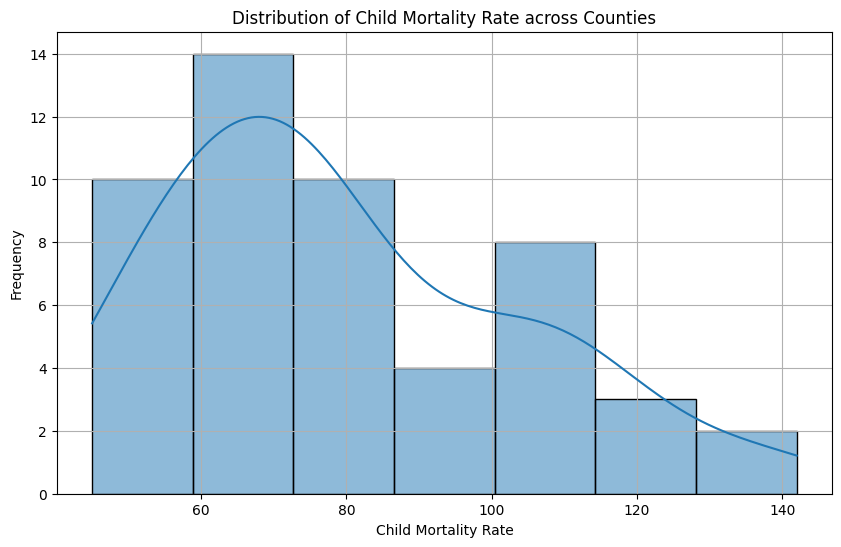

In [384]:
plt.figure(figsize=(10, 6))
sns.histplot(df_selected['Child Mortality Rate'], kde=True)
plt.title('Distribution of Child Mortality Rate across Counties')
plt.xlabel('Child Mortality Rate')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [425]:
'''
#county and child mortality rates lol higher FIPS code brings in Washington, pulaski etc.. kinda saying those are better for reduced
#child mortality rates
columns_correlation = ['FIPS', 'Child Mortality Rate']
df_correlation = df_selected[columns_correlation]
correlation_matrix = df_correlation.corr()

# Visualize the correlation matrix
plt.figure(figsize=(18, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Selected Variables')
plt.show()
'''
interested_cols = ['Child Mortality Rate', '% Fair or Poor Health', '% Low Birthweight', 
                                 '% Adults Reporting Currently Smoking', '% Adults with Obesity', '% Physically Inactive',
                                 '% With Access to Exercise Opportunities', '% Excessive Drinking', '% with Annual Mammogram',
                                 '% Vaccinated', '% Insufficient Sleep', '% Adults with Diabetes', '% Frequent Physical Distress',
                      '% Frequent Mental Distress']
#[col for col in df.columns if 'Rate' in col]
#columns_of_interest = ['FIPS']
#percent_cols = [col for col in df_cleaned.columns if '%' in col]


#cols_95_to_drop = [col for col in df_columns_of_interest.columns if '95%' in col]
#cols_unreliable_to_drop = [col for col in df_columns_of_interest.columns if 'Unreliable' in col]
#cols_to_drop = cols_95_to_drop + cols_unreliable_to_drop
#df_cleaned_rate = df_cleaned_rate.drop(cols_to_drop, axis=1)
#df_scaled_interested_columns

In [455]:
def scaled_df(columns_correlation, df_custom=None):
    columns_of_interest = columns_correlation
    if df_custom is None:
        df_columns_of_interest = df_cleaned[columns_of_interest]
    else:
        df_columns_of_interest = df_custom[columns_of_interest]
        
    df_cleaned_mortality = df_columns_of_interest.dropna(subset=['Child Mortality Rate'])
    nan_counts = df_cleaned_mortality.count().rename_axis('Feature').reset_index(name='Count')
    with open('interested_cols_nan_counts.txt', 'w') as f:
        f.write(nan_counts.to_string())
    scaler = StandardScaler()
    df_scaled_interested_columns = pd.DataFrame(scaler.fit_transform(df_cleaned_mortality), columns=df_cleaned_mortality.columns)
    return df_scaled_interested_columns

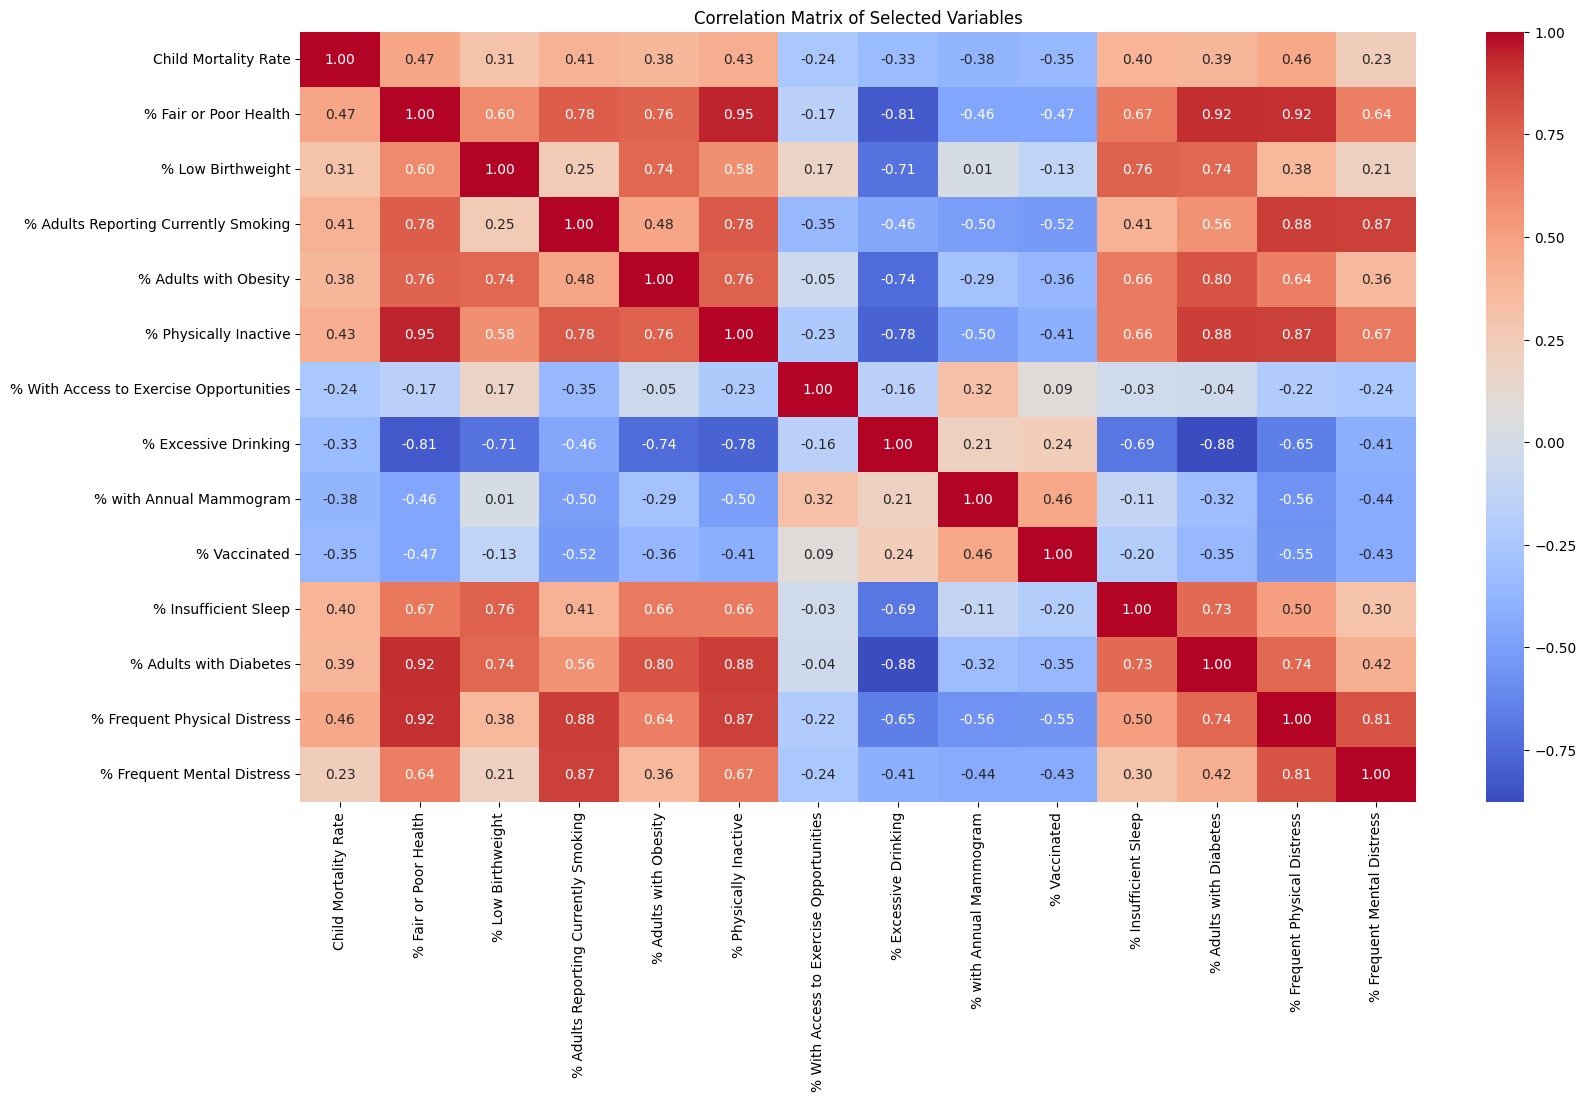

In [456]:
# correlation matrix for overall % column health behaviors
columns_correlation = ['Child Mortality Rate', '% Fair or Poor Health', '% Low Birthweight', 
                                 '% Adults Reporting Currently Smoking', '% Adults with Obesity', '% Physically Inactive',
                                 '% With Access to Exercise Opportunities', '% Excessive Drinking', '% with Annual Mammogram',
                                 '% Vaccinated', '% Insufficient Sleep', '% Adults with Diabetes', '% Frequent Physical Distress',
                      '% Frequent Mental Distress']

df_correlation = scaled_df(columns_correlation)
#df_correlation = df_scaled_interested_columns[columns_correlation] #df_selected[columns_correlation]
correlation_matrix = df_correlation.corr()

# Visualize the correlation matrix
plt.figure(figsize=(18, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Selected Variables')
plt.show()

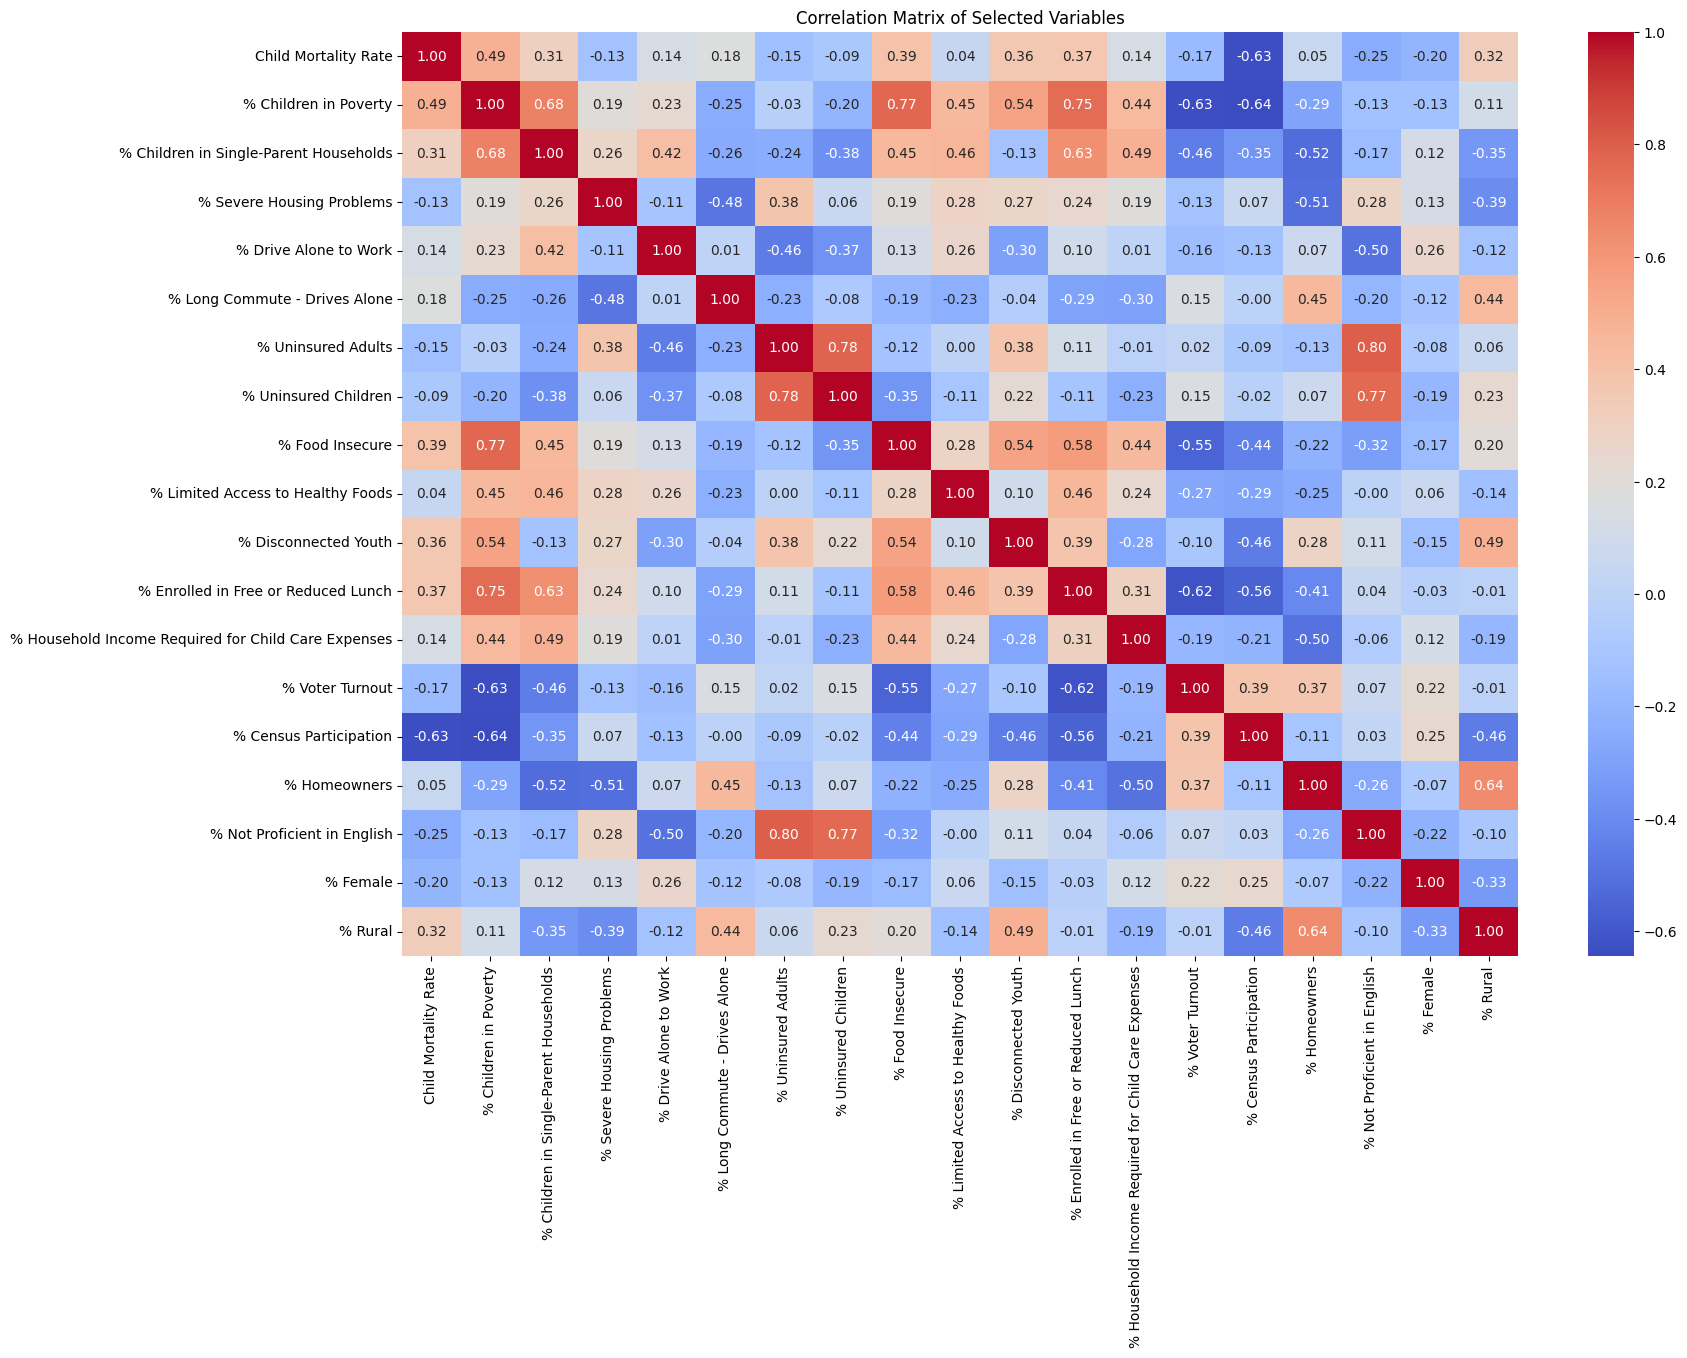

In [457]:
# correlation matrix for overall % and socio-economics
columns_correlation = [ 'Child Mortality Rate', '% Children in Poverty', '% Children in Single-Parent Households', 
                                 '% Severe Housing Problems', '% Drive Alone to Work', '% Long Commute - Drives Alone',
                                 '% Uninsured Adults', '% Uninsured Children', '% Food Insecure',
                                 '% Limited Access to Healthy Foods', '% Disconnected Youth', '% Enrolled in Free or Reduced Lunch',
                      '% Household Income Required for Child Care Expenses', '% Voter Turnout', '% Census Participation',
                      '% Homeowners', '% Not Proficient in English', '% Female', '% Rural']
df_correlation = scaled_df(columns_correlation)
#df_correlation = df_selected[columns_correlation]
correlation_matrix = df_correlation.corr()

# Visualize the correlation matrix
plt.figure(figsize=(18, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Selected Variables')
plt.show()

In [458]:
columns_of_interest = ['Child Mortality Rate', 'Child Mortality Rate (Black)', 'Child Mortality Rate (White)']
percent_cols = [col for col in df_cleaned.columns if '%' in col]
columns_of_interest = columns_of_interest + percent_cols
df_selected_race = df_cleaned[columns_of_interest]
df_selected_race = df_selected_race.dropna(subset=['Child Mortality Rate'])
#df_selected_race['Child Mortality Rate (Black)']

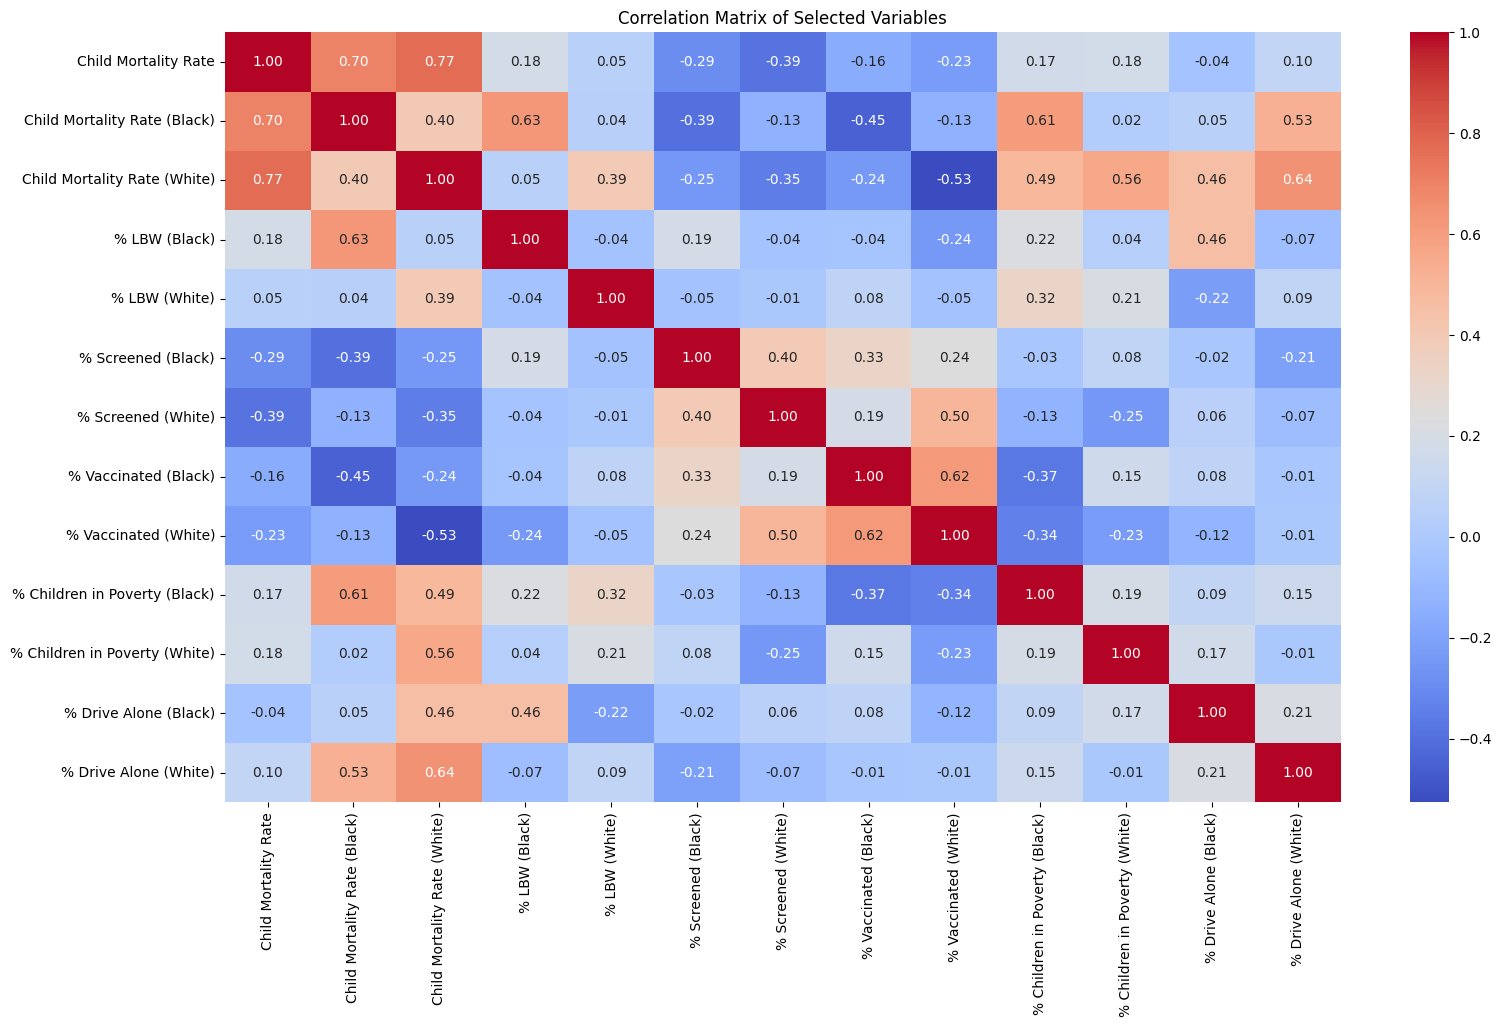

In [459]:
#we will repeat the above parameters but focus on black white races, hispanic, asian and aian are limited data so excluding them for now
# correlation matrix for race data and health / social behaviors
columns_correlation = ['Child Mortality Rate', 'Child Mortality Rate (Black)', 'Child Mortality Rate (White)',
                       '% LBW (Black)', '% LBW (White)',
                                 '% Screened (Black)', '% Screened (White)', '% Vaccinated (Black)', '% Vaccinated (White)',
                                 '% Children in Poverty (Black)', '% Children in Poverty (White)', '% Drive Alone (Black)',
                                 '% Drive Alone (White)']
df_correlation = scaled_df(columns_correlation, df_selected_race) #df_selected_race[columns_correlation]
correlation_matrix = df_correlation.corr()

# Visualize the correlation matrix
plt.figure(figsize=(18, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Selected Variables')
plt.show()

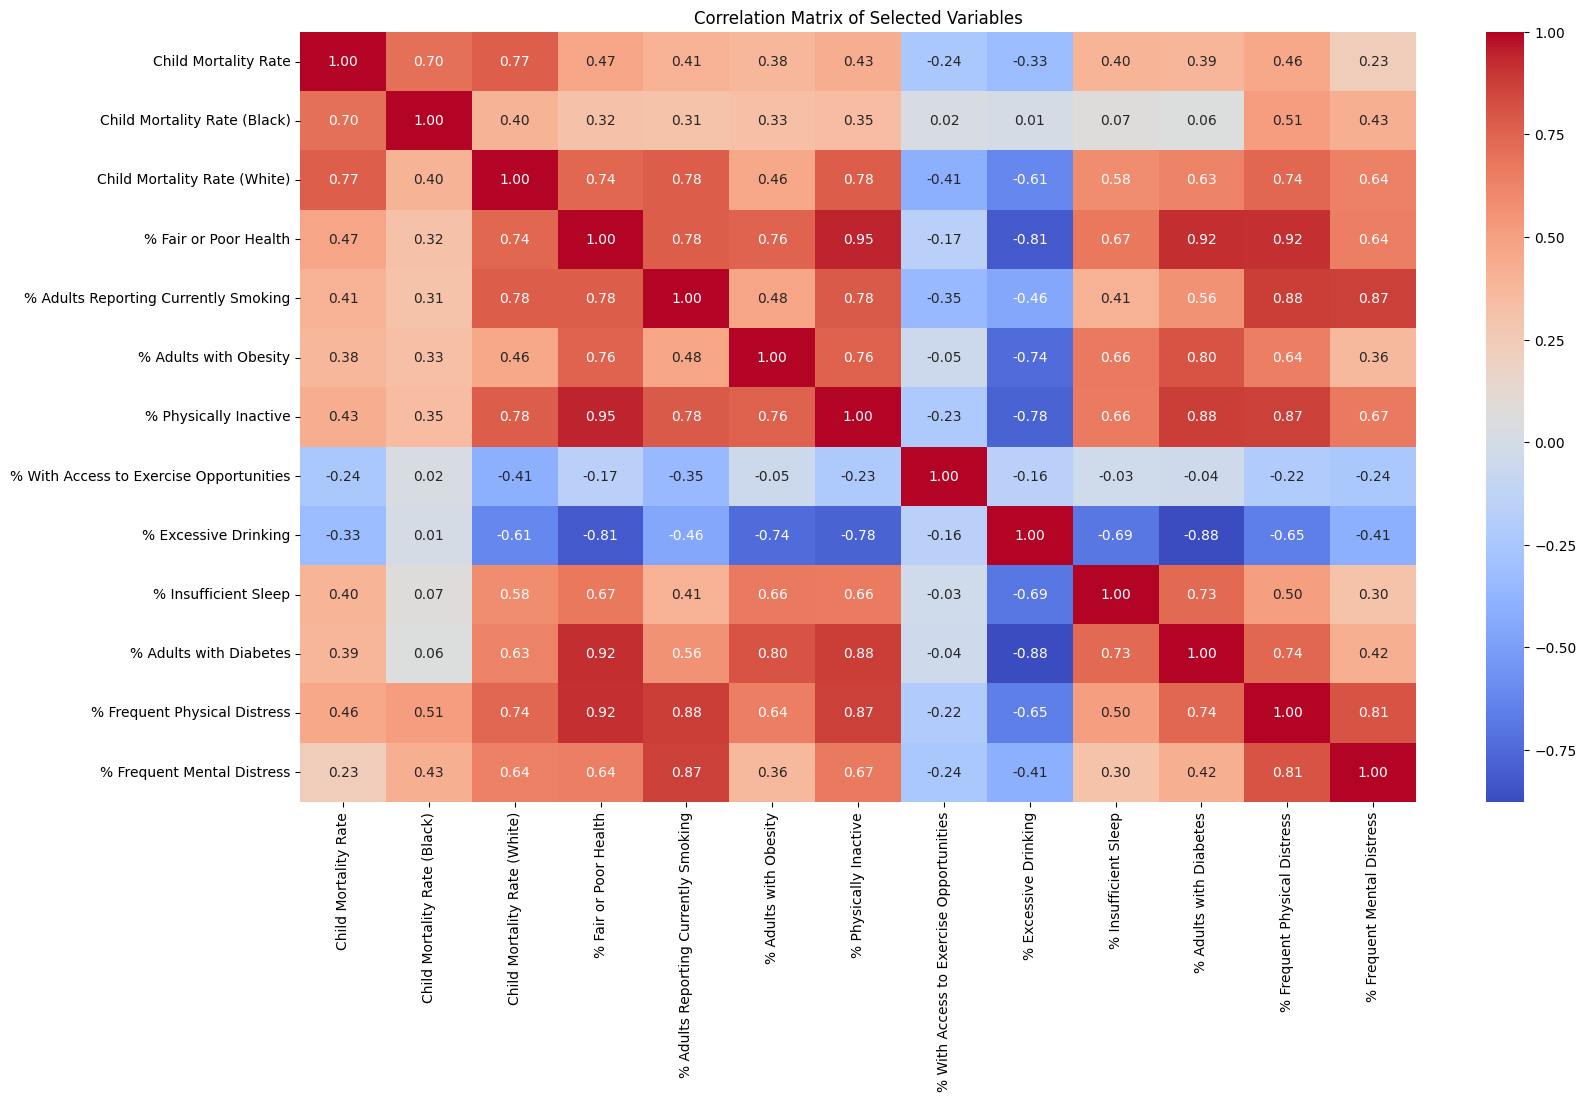

In [460]:
# correlation matrix including race mortality and overall health behaviors
#Race data available and looked into earlier '% Low Birthweight', '% with Annual Mammogram','% Vaccinated', 
columns_correlation = ['Child Mortality Rate', 'Child Mortality Rate (Black)', 'Child Mortality Rate (White)',
                       '% Fair or Poor Health', 
                                 '% Adults Reporting Currently Smoking', '% Adults with Obesity', '% Physically Inactive',
                                 '% With Access to Exercise Opportunities', '% Excessive Drinking', 
                                 '% Insufficient Sleep', '% Adults with Diabetes', '% Frequent Physical Distress',
                      '% Frequent Mental Distress']
df_correlation = scaled_df(columns_correlation, df_selected_race) #df_selected_race[columns_correlation]
correlation_matrix = df_correlation.corr()

# Visualize the correlation matrix
plt.figure(figsize=(18, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Selected Variables')
plt.show()

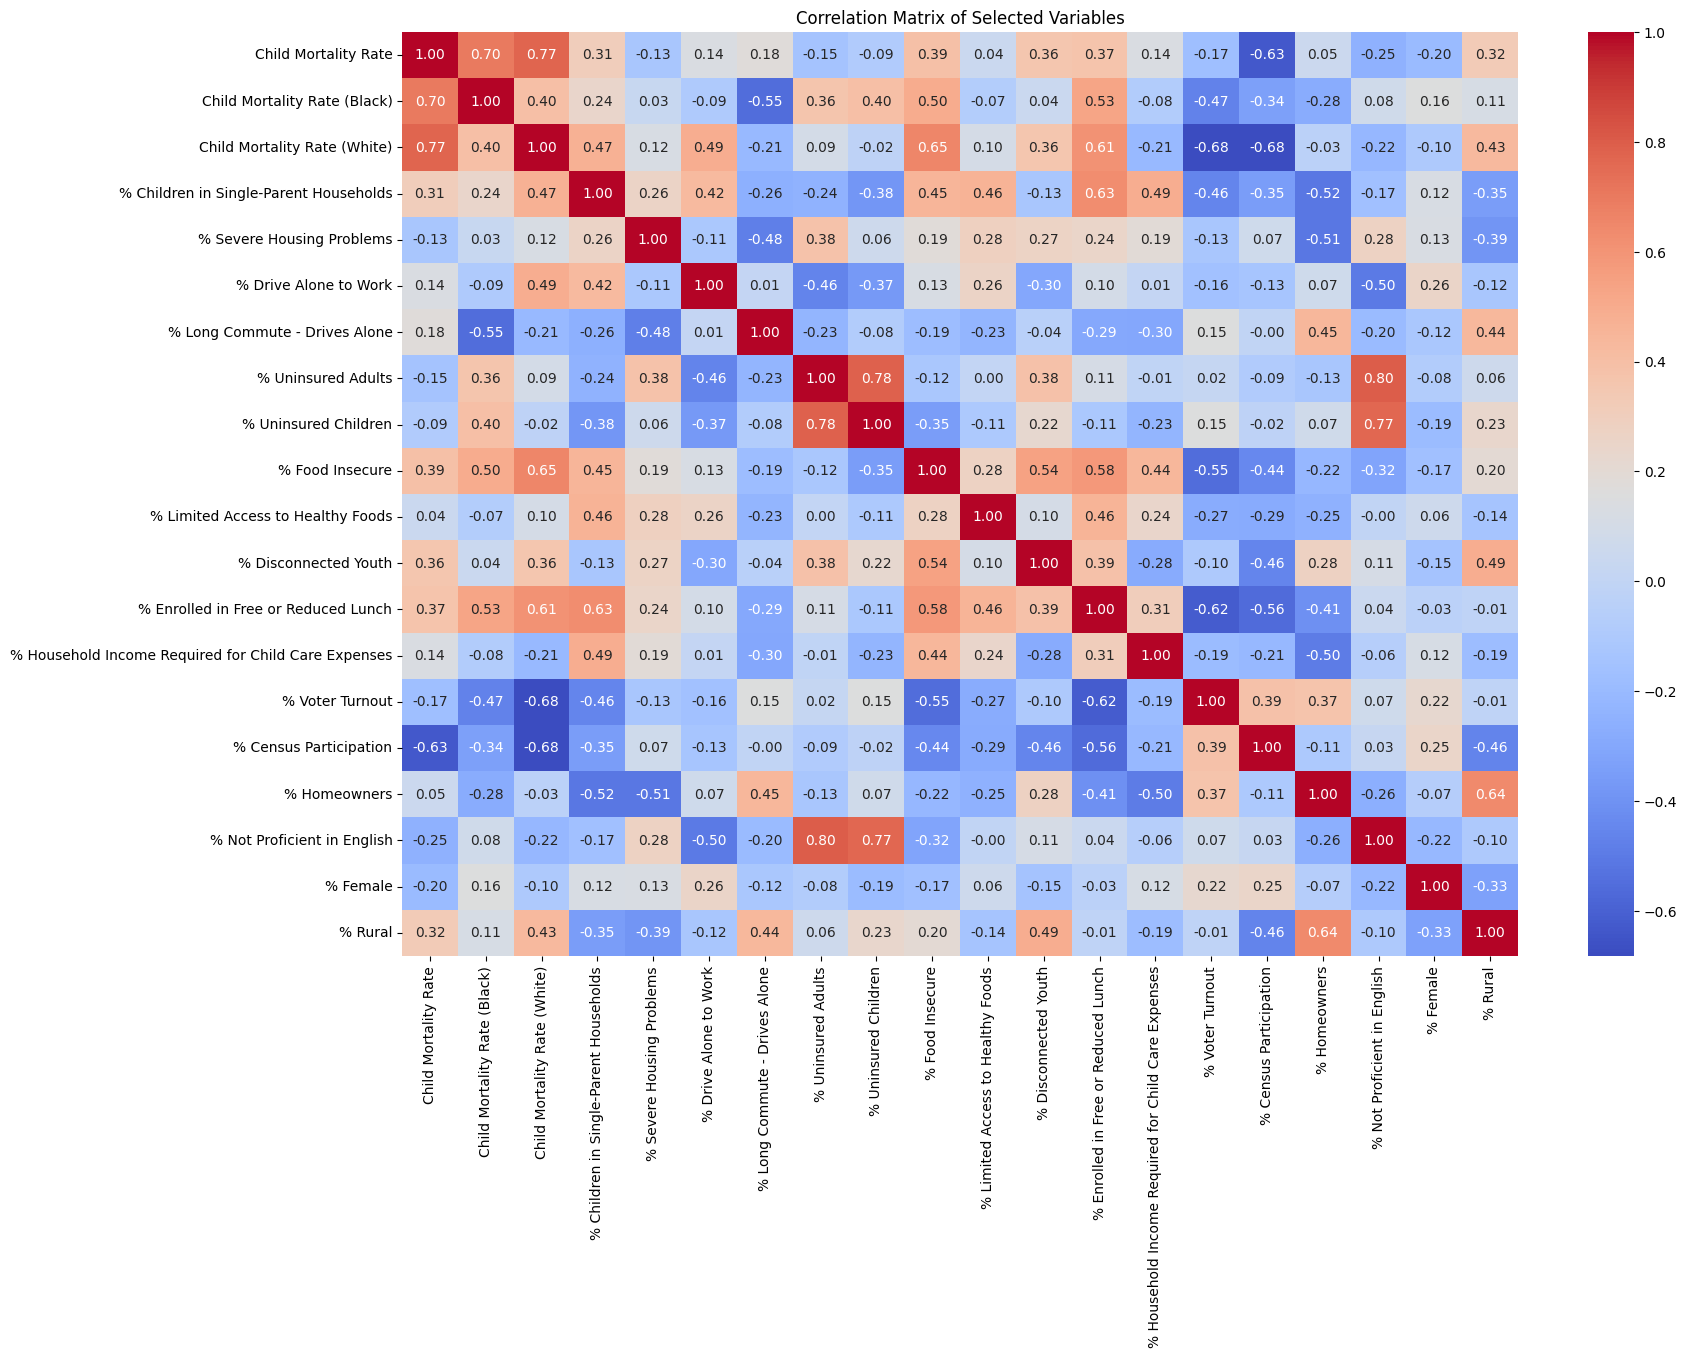

In [461]:
# correlation matrix for overall data driven by race and socio-economics
columns_correlation = ['Child Mortality Rate', 'Child Mortality Rate (Black)', 'Child Mortality Rate (White)',
                       '% Children in Single-Parent Households',
                                 '% Severe Housing Problems', '% Drive Alone to Work', '% Long Commute - Drives Alone',
                                 '% Uninsured Adults', '% Uninsured Children', '% Food Insecure',
                                 '% Limited Access to Healthy Foods', '% Disconnected Youth', '% Enrolled in Free or Reduced Lunch',
                      '% Household Income Required for Child Care Expenses', '% Voter Turnout', '% Census Participation',
                      '% Homeowners', '% Not Proficient in English', '% Female', '% Rural']
df_correlation = scaled_df(columns_correlation, df_selected_race) #df_selected_race[columns_correlation]
correlation_matrix = df_correlation.corr()

# Visualize the correlation matrix
plt.figure(figsize=(18, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Selected Variables')
plt.show()

In [393]:
#placeholder for scatter plots, etc..

In [404]:
#remove for sure non-used columns
rate_cols = [col for col in df.columns if 'Rate' in col]
#columns_of_interest = ['FIPS']
#percent_cols = [col for col in df_cleaned.columns if '%' in col]
columns_of_interest = rate_cols
df_cleaned_rate = df[columns_of_interest]

cols_95_to_drop = [col for col in df_cleaned_rate.columns if '95%' in col]
cols_unreliable_to_drop = [col for col in df_cleaned_rate.columns if 'Unreliable' in col]
cols_to_drop = cols_95_to_drop + cols_unreliable_to_drop
df_cleaned_rate = df_cleaned_rate.drop(cols_to_drop, axis=1)
df_selected_rate = df_cleaned_rate.dropna(subset=['Child Mortality Rate'])

In [462]:
rate_nan_counts = df_selected_rate.count().rename_axis('Feature').reset_index(name='Count')
with open('nan_counts.txt', 'w') as f:
    f.write(rate_nan_counts.to_string())
drop_aian = [col for col in df_selected_rate.columns if 'AIAN' in col]
drop_asian = [col for col in df_selected_rate.columns if 'Asian' in col]
drop_hispanic = [col for col in df_selected_rate.columns if 'Hispanic' in col]
cols_to_drop = drop_aian + drop_asian + drop_hispanic
df_selected_rate = df_selected_rate.drop(cols_to_drop, axis=1)

In [463]:
df_selected_rate.columns

Index(['Years of Potential Life Lost Rate', 'YPLL Rate (Black)',
       'YPLL Rate (White)', 'Chlamydia Rate', 'Teen Birth Rate',
       'Teen Birth Rate (Black)', 'Teen Birth Rate (White)',
       'Primary Care Physicians Rate', 'Dentist Rate',
       'Mental Health Provider Rate', 'Preventable Hospitalization Rate',
       'Preventable Hosp. Rate (Black)', 'Preventable Hosp. Rate (White)',
       'Social Association Rate', 'Injury Death Rate',
       'Injury Death Rate (Black)', 'Injury Death Rate (White)',
       'Age-Adjusted Death Rate', 'Child Mortality Rate',
       'Child Mortality Rate (Black)', 'Child Mortality Rate (White)',
       'Infant Mortality Rate', 'Infant Mortality Rate (Black)',
       'Infant Mortality Rate (White)', 'HIV Prevalence Rate',
       'Drug Overdose Mortality Rate', 'Drug Overdose Mortality Rate (Black)',
       'Drug Overdose Mortality Rate (White)',
       'Other Primary Care Provider Rate', 'High School Graduation Rate',
       'Homicide Rate', 'Hom

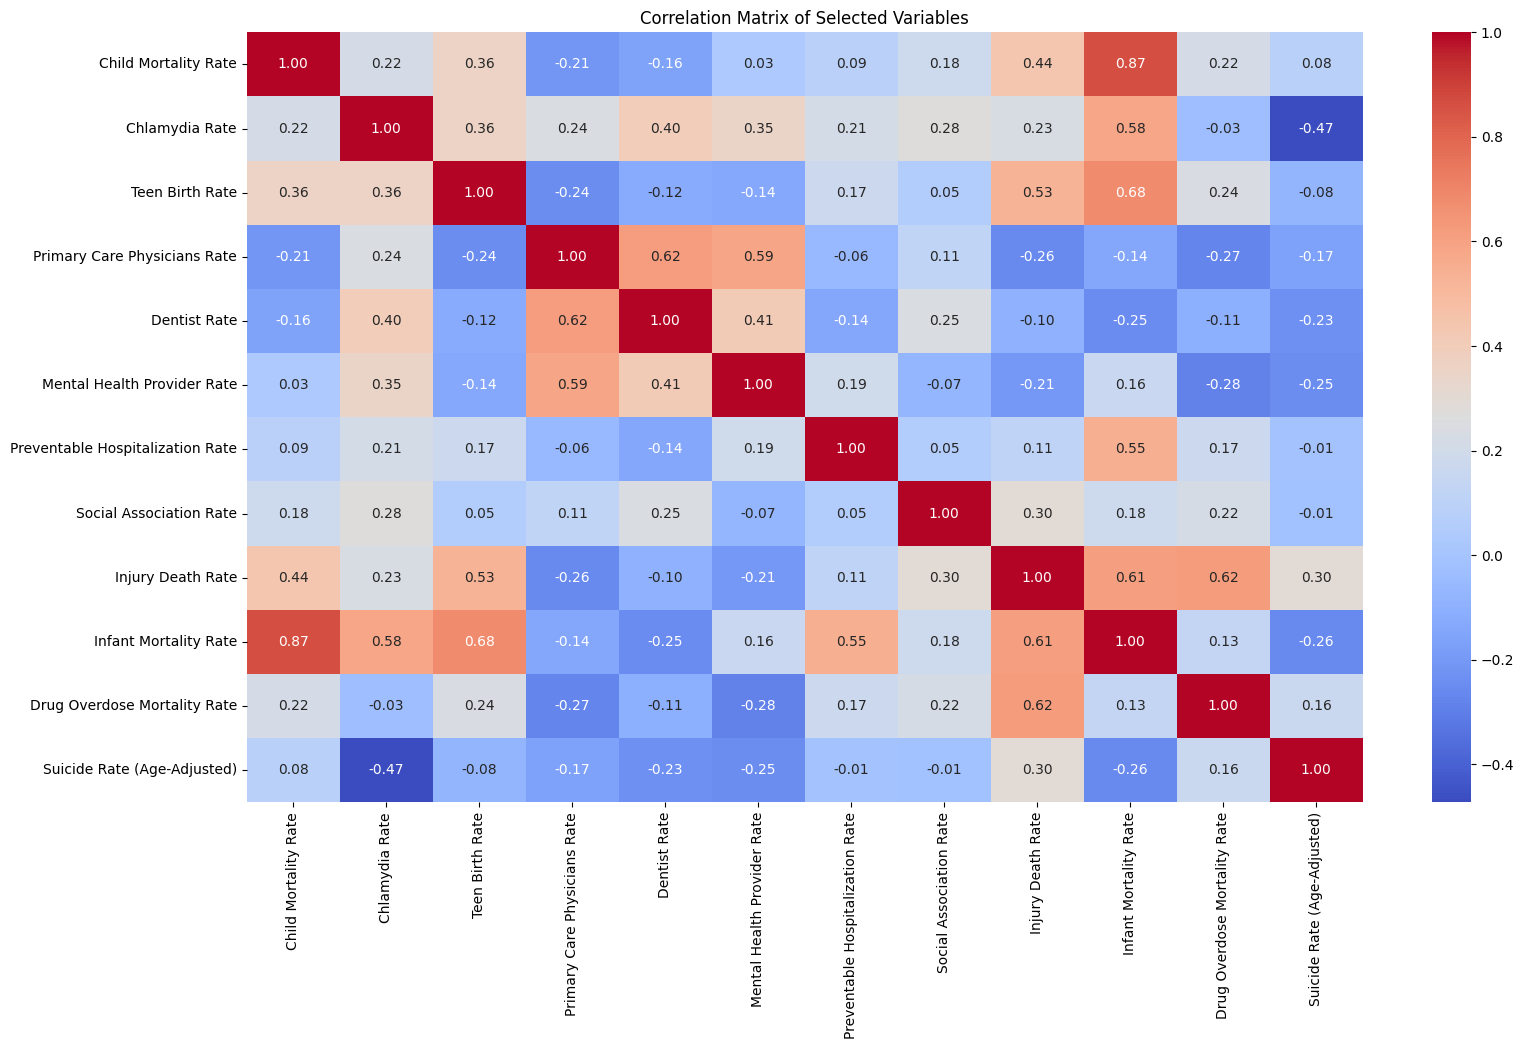

In [466]:
# correlation matrix for overall rate data and health behaviors
columns_correlation = ['Child Mortality Rate', 'Chlamydia Rate', 
                                 'Teen Birth Rate', 'Primary Care Physicians Rate', 'Dentist Rate',
                                 'Mental Health Provider Rate', 'Preventable Hospitalization Rate', 'Social Association Rate',
                                 'Injury Death Rate', 'Infant Mortality Rate', 'Drug Overdose Mortality Rate',
                      'Suicide Rate (Age-Adjusted)']
df_correlation = scaled_df(columns_correlation, df_selected_rate) #df_selected_rate[columns_correlation]
correlation_matrix = df_correlation.corr()

# Visualize the correlation matrix
plt.figure(figsize=(18, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Selected Variables')
plt.show()

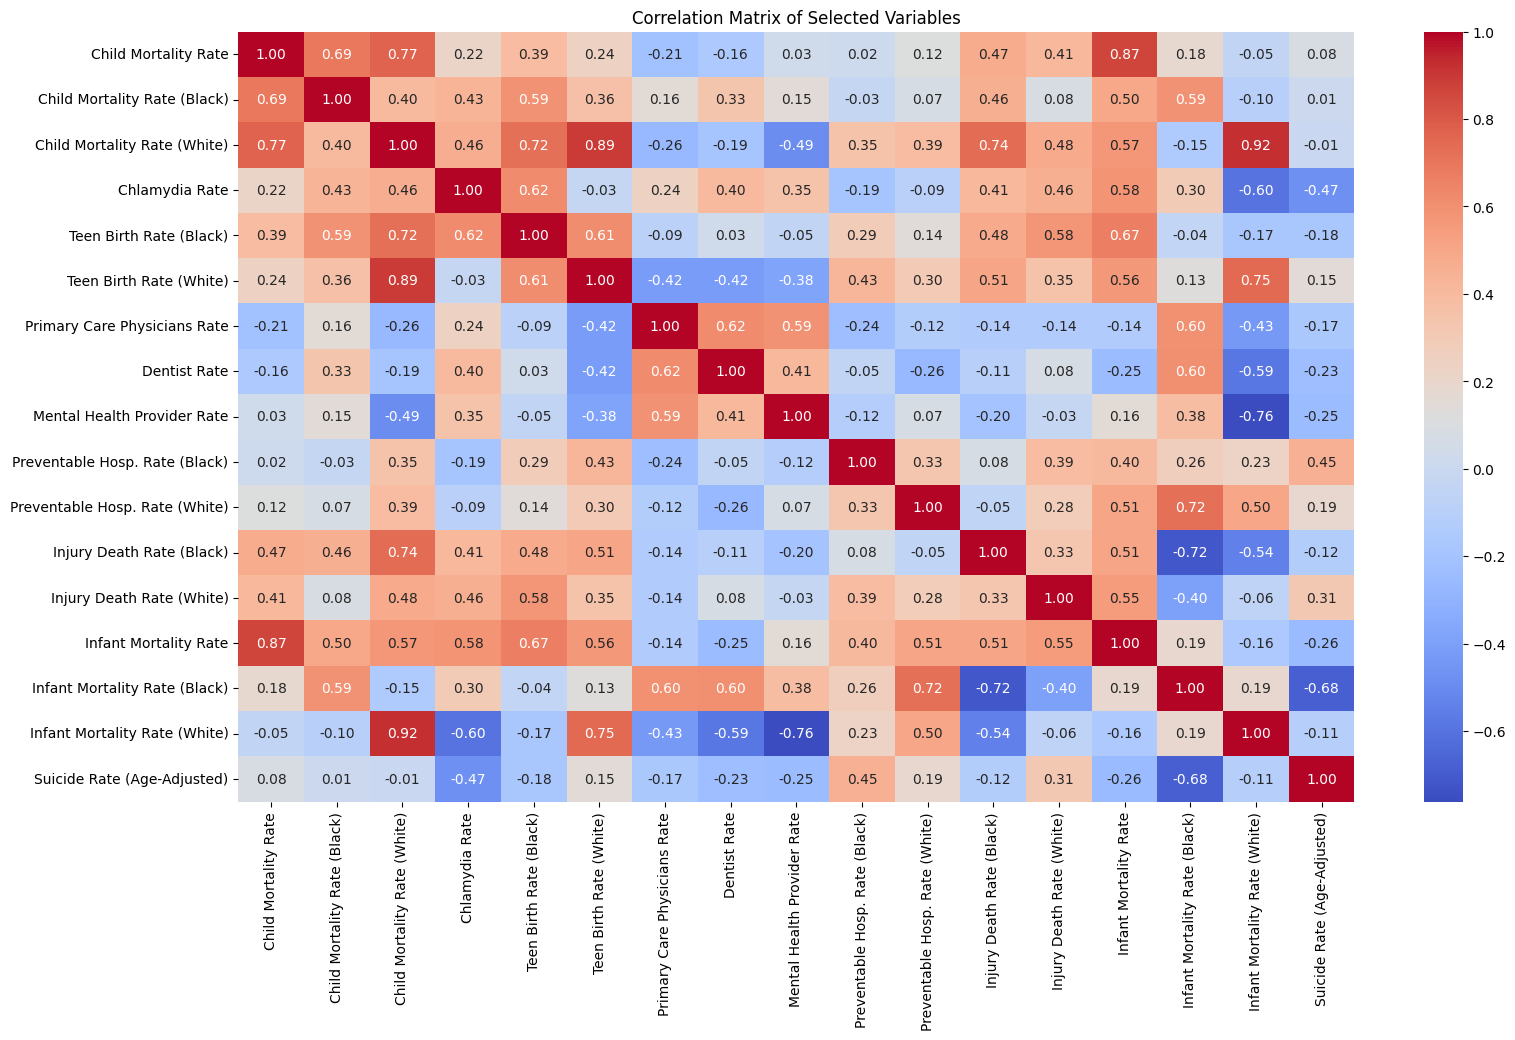

In [468]:
# correlation matrix for race specific  social-health behaviors
columns_correlation = ['Child Mortality Rate', 'Child Mortality Rate (Black)', 'Child Mortality Rate (White)', 'Chlamydia Rate', 
                                 'Teen Birth Rate (Black)', 'Teen Birth Rate (White)', 'Primary Care Physicians Rate', 'Dentist Rate',
                                 'Mental Health Provider Rate', 'Preventable Hosp. Rate (Black)', 'Preventable Hosp. Rate (White)',
                                 'Injury Death Rate (Black)','Injury Death Rate (White)', 'Infant Mortality Rate', 
                      'Infant Mortality Rate (Black)', 'Infant Mortality Rate (White)', 'Suicide Rate (Age-Adjusted)']
df_correlation = scaled_df(columns_correlation, df_selected_rate) #df_selected_rate[columns_correlation]
correlation_matrix = df_correlation.corr()

# Visualize the correlation matrix
plt.figure(figsize=(18, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Selected Variables')
plt.show()

In [364]:
df_selected_rate.columns

Index(['FIPS', 'Years of Potential Life Lost Rate', 'YPLL Rate (Black)',
       'YPLL Rate (White)', 'Chlamydia Rate', 'Teen Birth Rate',
       'Teen Birth Rate (Black)', 'Teen Birth Rate (White)',
       'Primary Care Physicians Rate', 'Dentist Rate',
       'Mental Health Provider Rate', 'Preventable Hospitalization Rate',
       'Preventable Hosp. Rate (Black)', 'Preventable Hosp. Rate (White)',
       'Social Association Rate', 'Injury Death Rate',
       'Injury Death Rate (Black)', 'Injury Death Rate (White)',
       'Age-Adjusted Death Rate', 'Child Mortality Rate',
       'Child Mortality Rate (Black)', 'Child Mortality Rate (White)',
       'Infant Mortality Rate', 'Infant Mortality Rate (Black)',
       'Infant Mortality Rate (White)', 'HIV Prevalence Rate',
       'Drug Overdose Mortality Rate', 'Drug Overdose Mortality Rate (Black)',
       'Drug Overdose Mortality Rate (White)',
       'Other Primary Care Provider Rate', 'High School Graduation Rate',
       'Homicide Rat

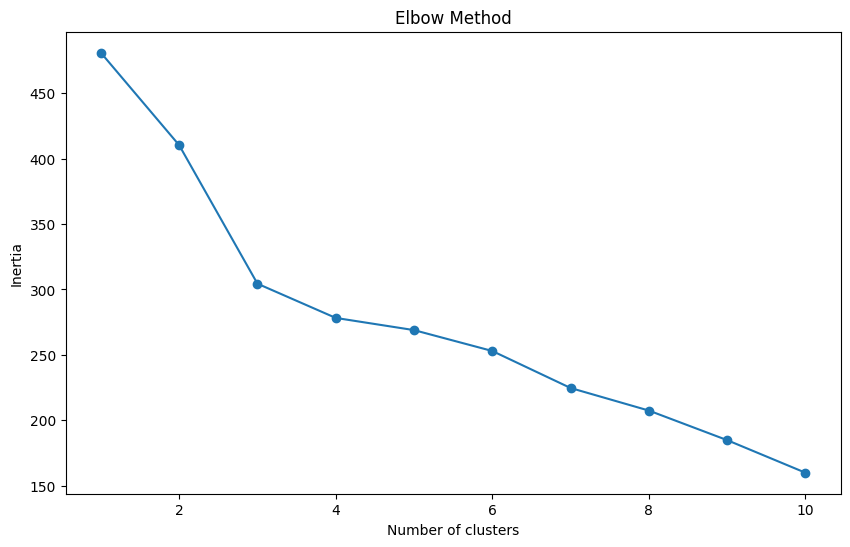

In [411]:
#DOING COUNTY CLUSTERING 
#columns_of_interest = [
#    'Child Mortality Rate', 'Median Household Income', 
#    '% Completed High School', '% Some College', '% Uninsured', '% Children in Poverty', 
#    'Population', '% Black', '% Hispanic', '% Non-Hispanic White', 
#    'Average Number of Physically Unhealthy Days', 'Average Number of Mentally Unhealthy Days'
#]

#columns_of_interest = [
#    'Child Mortality Rate', 'Child Mortality Rate (Black)', 'Child Mortality Rate (White)', 'Chlamydia Rate', 
#                                 'Teen Birth Rate (Black)', 'Teen Birth Rate (White)', 'Primary Care Physicians Rate', 'Dentist Rate',
#                                 'Mental Health Provider Rate', 'Preventable Hosp. Rate (Black)', 'Preventable Hosp. Rate (White)',
#                                 'Injury Death Rate (Black)','Injury Death Rate (White)','Suicide Rate (Age-Adjusted)'
#]
'''
columns_of_interest = ['Child Mortality Rate', 'Child Mortality Rate (Black)', 'Child Mortality Rate (White)',
                       '% Children in Single-Parent Households',
                                 '% Severe Housing Problems', 
                                 '% Uninsured Adults', '% Uninsured Children', '% Food Insecure',
                                 '% Limited Access to Healthy Foods', '% Disconnected Youth', '% Enrolled in Free or Reduced Lunch',
                      '% Household Income Required for Child Care Expenses', '% Voter Turnout', '% Census Participation',
                      '% Homeowners', '% Not Proficient in English', '% Female', '% Rural']


imputer = SimpleImputer(strategy='mean')
df_imputed = imputer.fit_transform(df_cleaned[columns_of_interest])
# Convert imputed data back to DataFrame to retain column names
df_imputed = pd.DataFrame(df_imputed, columns=columns_of_interest, index=df_cleaned.index)

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_imputed)
# Convert scaled data back to DataFrame
df_scaled = pd.DataFrame(df_scaled, columns=columns_of_interest, index=df_cleaned.index)


columns_of_interest = [
    'Child Mortality Rate', 
    '% Completed High School', '% Some College', '% Uninsured', '% Children in Poverty', 
    'Average Number of Physically Unhealthy Days', 'Average Number of Mentally Unhealthy Days'
]
#positive correlated columns below
columns_of_interest = ['Child Mortality Rate', 
'% Fair or Poor Health', '% Adults Reporting Currently Smoking', '% Adults with Obesity', 
                       '% Physically Inactive', '% Frequent Physical Distress', '% Frequent Mental Distress', 
                       '% Children in Single-Parent Households', '% Drive Alone to Work', '% Food Insecure', 
                       '% Enrolled in Free or Reduced Lunch', '% Rural', 'Chlamydia Rate', 'Teen Birth Rate (Black)', 
                       'Teen Birth Rate (White)', 'Injury Death Rate (Black)', 'Infant Mortality Rate']
'''
#negative correlated columns below
#columns_of_interest = ['Child Mortality Rate', '% Voter Turnout', '% Census Participation', 'Median Household Income']
columns_of_interest = ['Child Mortality Rate', '% Voter Turnout', '% Census Participation', '% Screened (Black)', 
                       '% Vaccinated (Black)', '% Long Commute - Drives Alone', '% Homeowners',
                      '% Screened (White)', '% Vaccinated (White)', '% With Access to Exercise Opportunities', 
                       '% Excessive Drinking', 'Mental Health Provider Rate', 'Primary Care Physicians Rate']

                       
df_selected = df_cleaned[columns_of_interest].dropna()

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_selected)
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)


# Plotting the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [412]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_selected['Cluster'] = kmeans.fit_predict(df_scaled)
cluster_means = df_selected.groupby('Cluster').mean()

print(cluster_means)

         Child Mortality Rate  % Voter Turnout  % Census Participation  \
Cluster                                                                  
0                   74.400000        56.060000               59.080000   
1                   58.500000        56.450000               63.433333   
2                   87.772727        48.145455               51.904545   
3                   64.250000        54.200000               63.725000   

         % Screened (Black)  % Vaccinated (Black)  \
Cluster                                             
0                 36.800000             43.000000   
1                 34.333333             43.000000   
2                 33.818182             33.590909   
3                 40.500000             37.750000   

         % Long Commute - Drives Alone  % Homeowners  % Screened (White)  \
Cluster                                                                    
0                            46.800000     77.400000           32.200000   
1       

In [413]:
df_selected['County'] = df_cleaned['County']
for i in range(optimal_k):  # 'k' is the number of clusters you chose
    print(f"Counties in Cluster {i}:")
    print(df_selected[df_selected['Cluster'] == i]['County'].head(), '\n')

Counties in Cluster 0:
27           Grant
30      Hot Spring
41    Little River
43          Lonoke
63          Saline
Name: County, dtype: object 

Counties in Cluster 1:
4           Benton
23        Faulkner
26         Garland
32    Independence
58            Pope
Name: County, dtype: object 

Counties in Cluster 2:
1     Arkansas
2       Ashley
6      Bradley
9       Chicot
14    Columbia
Name: County, dtype: object 

Counties in Cluster 3:
16     Craighead
60       Pulaski
66     Sebastian
72    Washington
Name: County, dtype: object 



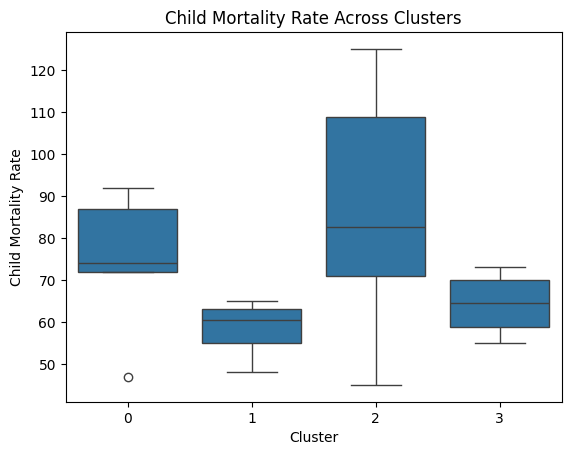

In [414]:
sns.boxplot(x='Cluster', y='Child Mortality Rate', data=df_selected)
plt.title('Child Mortality Rate Across Clusters')
plt.show()

/home/nagarajbr/Downloads/.venv310jupyter/lib/python3.10/site-packages/sklearn/manifold/_mds.py:626: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


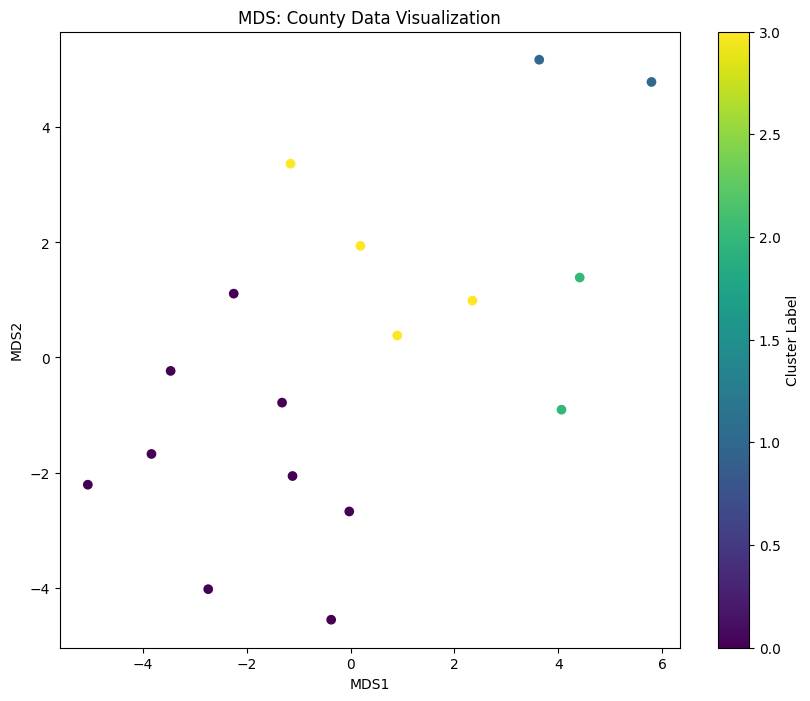

In [352]:
from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Assuming df_scaled is your scaled DataFrame ready for clustering
mds = MDS(n_components=2, random_state=42)
df_mds = mds.fit_transform(df_scaled)  # Transform your scaled data

plt.figure(figsize=(10, 8))
plt.scatter(df_mds[:, 0], df_mds[:, 1], c=kmeans.labels_, cmap='viridis')  # Assuming you've done KMeans clustering
plt.title('MDS: County Data Visualization')
plt.xlabel('MDS1')
plt.ylabel('MDS2')
plt.colorbar(label='Cluster Label')
plt.show()

In [353]:
columns_of_interest = [
    'Child Mortality Rate (Black)', 'Child Mortality Rate (White)', 'Child Mortality Rate', 
    'Median Household Income', 'Household Income (Black)', 'Household Income (White)',
    '% Children in Poverty', '% Children in Poverty (Black)', '% Children in Poverty (White)',
    'Food Environment Index', '% Completed High School', '% Some College',
    'Income Ratio', 'Social Association Rate', 'Severe Housing Cost Burden', 
    'Age-Adjusted Mortality (Black)', 'Age-Adjusted Mortality (White)', 
    'Average Grade Performance (Black)', 'Average Grade Performance (White)'
]

# Filter the dataset
df_filtered = df[columns_of_interest]

# Handle missing values
imputer = SimpleImputer(strategy='mean')
df_imputed = imputer.fit_transform(df_filtered)
df_imputed = pd.DataFrame(df_imputed, columns=columns_of_interest)

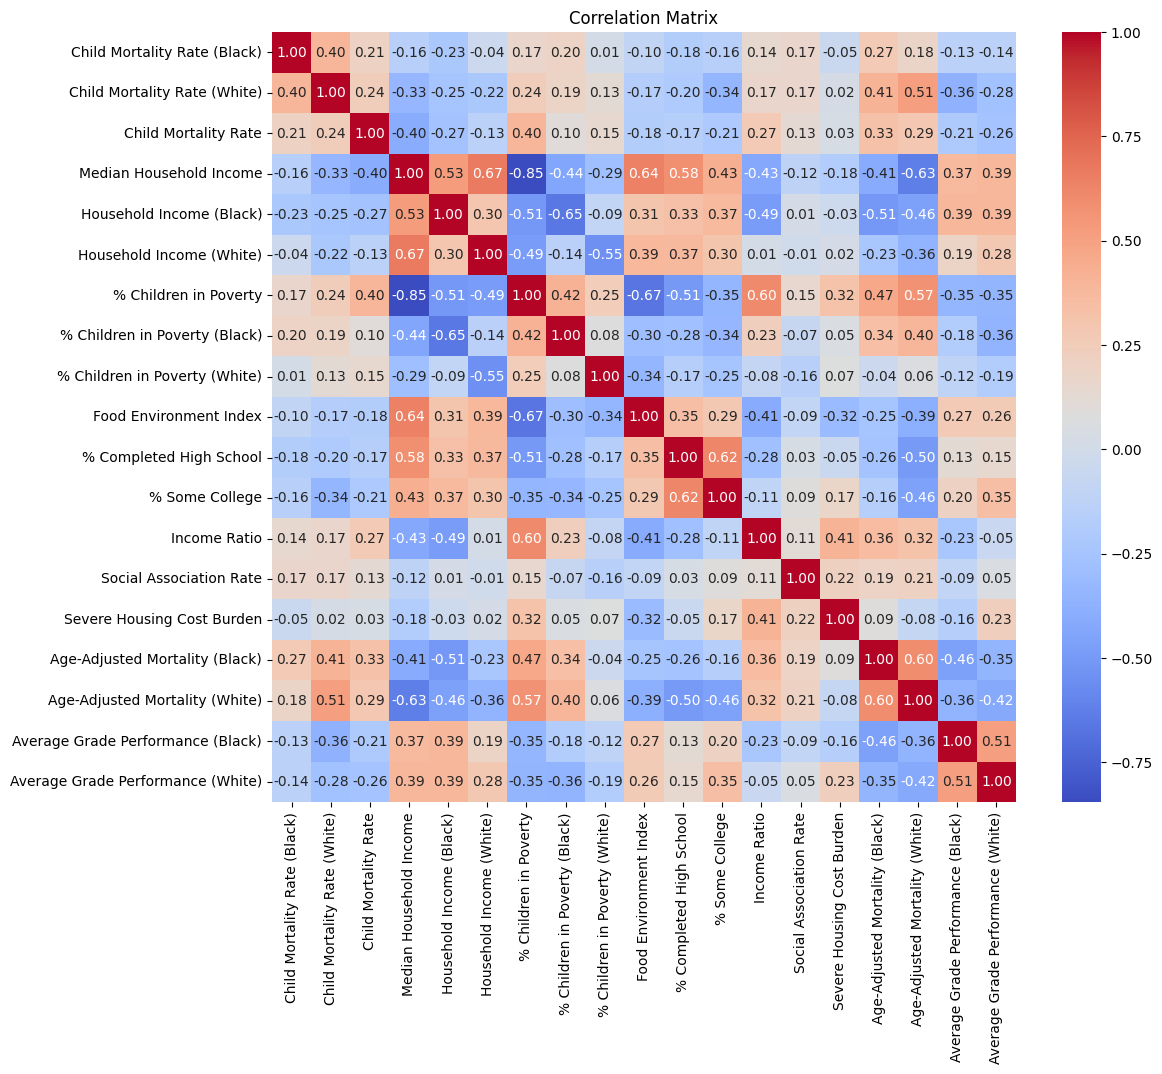

In [354]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_imputed)
df_scaled = pd.DataFrame(df_scaled, columns=columns_of_interest)

# Calculate correlation matrix
correlation_matrix = df_scaled.corr()

# Visualize the correlation matrix, focusing on 'Child Mortality Rate (Black)' and 'Child Mortality Rate (White)'
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

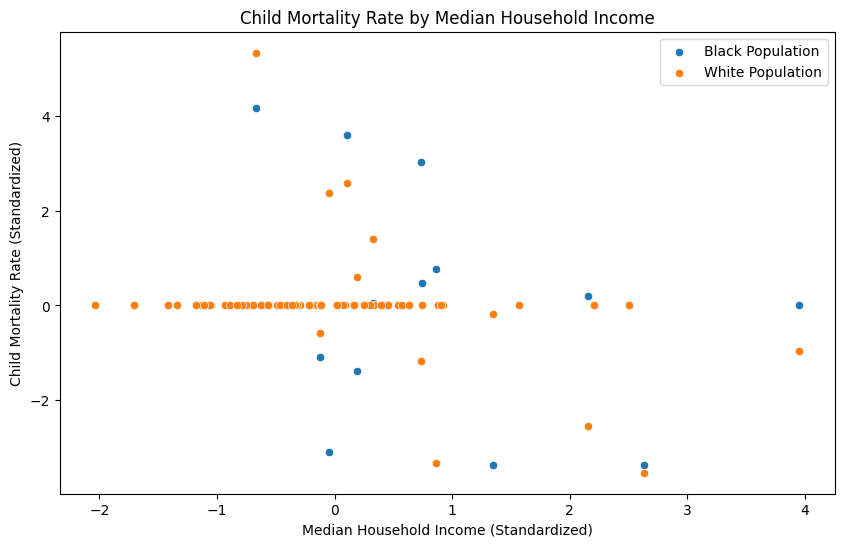

In [355]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_scaled, x='Median Household Income', y='Child Mortality Rate (Black)', label='Black Population')
sns.scatterplot(data=df_scaled, x='Median Household Income', y='Child Mortality Rate (White)', label='White Population')
plt.title('Child Mortality Rate by Median Household Income')
plt.xlabel('Median Household Income (Standardized)')
plt.ylabel('Child Mortality Rate (Standardized)')
plt.legend()
plt.show()

In [356]:
variables_for_clustering = ['Child Mortality Rate (Black)', 'Child Mortality Rate (White)', 'Median Household Income', '% Children in Poverty']

# Perform KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Adjust the number of clusters as needed based on your analysis
df_imputed['Cluster'] = kmeans.fit_predict(df_scaled[variables_for_clustering])

# Analyze clusters
for cluster in sorted(df_imputed['Cluster'].unique()):
    cluster_data = df_imputed[df_imputed['Cluster'] == cluster]
    print(f"Cluster {cluster} Summary Statistics:")
    print(cluster_data[variables_for_clustering].mean())

Cluster 0 Summary Statistics:
Child Mortality Rate (Black)       95.857143
Child Mortality Rate (White)       54.263736
Median Household Income         64884.285714
% Children in Poverty              15.428571
dtype: float64
Cluster 1 Summary Statistics:
Child Mortality Rate (Black)      102.365591
Child Mortality Rate (White)       62.702233
Median Household Income         39940.096774
% Children in Poverty              32.516129
dtype: float64
Cluster 2 Summary Statistics:
Child Mortality Rate (Black)      102.166667
Child Mortality Rate (White)       62.698381
Median Household Income         48421.184211
% Children in Poverty              23.736842
dtype: float64


In [ ]:
[col for col in df_cleaned.columns if '%' in col]

In [ ]:
'''
# Scatter plots for variables with strong correlations to 'Child Mortality Rate'
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# % Children in Poverty vs. Child Mortality Rate
sns.scatterplot(ax=ax[0], data=df_selected, x='% Children in Poverty', y='Child Mortality Rate')
ax[0].set_title('% Children in Poverty vs. Child Mortality Rate')
ax[0].set_xlabel('% Children in Poverty')
ax[0].set_ylabel('Child Mortality Rate')

# % Black vs. Child Mortality Rate
sns.scatterplot(ax=ax[2], data=df_selected, x='% Black', y='Child Mortality Rate')
ax[2].set_title('% Black vs. Child Mortality Rate')
ax[2].set_xlabel('% Black')
ax[2].set_ylabel('Child Mortality Rate')

plt.tight_layout()
plt.show()
'''